# CDSDS 542 Deep Learning for Data Science - Discussion 9: ViT

# Task: ViT for image classification on CIFAR10

In [ ]:
# module
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import timm, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Load data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# For faster training, we take the subset of CIFAR10 for training
# Sampling quantity for each category (total 10*1000=10000)
full_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

subset_size_per_class = 1000
indices = []
targets = np.array(full_train.targets)

for class_idx in range(10):
    class_indices = np.where(targets == class_idx)[0]
    chosen = np.random.choice(class_indices, subset_size_per_class, replace=False)
    indices.extend(chosen)

subset_train = Subset(full_train, indices)
print(f"Subset size = {len(subset_train)}")
trainloader = DataLoader(subset_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# Use this loader for full dataset trainning:
# trainloader = DataLoader(full_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:03<00:00, 47.0MB/s]


Subset size = 10000


## Patch Embedding

Unlike CNNs that process pixels locally, ViT splits an image into **non-overlapping patches**.
Each patch is flattened and projected linearly into an embedding vector.

Here, the Conv2D layer with `kernel_size=patch_size` and `stride=patch_size`
acts as both **patch extractor and linear projection**.

- Input shape: `[B, 3, H, W]`
- Output shape: `[B, N, D]` where  
  $N = (H / P)^2$ patches, and $D$ is the embedding dimension.


### From Images to Patch Embeddings  

1. **Split the image into patches** – e.g., an image of size 224×224 might be broken into 14×14 patches (each 16×16 pixels) to reduce the quadratic cost of self-attention.
2. **Linear projection of patches into embedding vectors** – Once each patch is flattened/processed, it is mapped to a D-dimensional embedding, so it can serve as a “token” for the transformer.
3. **Prepend a special [CLS] token**, add **positional embeddings**, and feed into a standard transformer encoder.

**Why this matters:**  
Transformers compute pairwise attention across tokens. If we used every pixel in a 224×224 image (≈ 50 k pixels) as a token, the attention complexity would be enormous. Splitting into, say, 256 patches reduces tokens dramatically and makes the process manageable — while preserving spatial structure through learned positional embeddings.

---

*To better understand this, find more readings at:*
1. https://www.pinecone.io/learn/series/image-search/vision-transformers/?utm_source=chatgpt.com
2. https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html?utm_source=chatgpt.com
3. https://medium.com/advanced-deep-learning/understanding-vision-transformers-vit-70ca8d817ff3
4. https://theaisummer.com/vision-transformer/?utm_source=chatgpt.com
5. https://medium.com/%40fernandopalominocobo/demystifying-visual-transformers-with-pytorch-understanding-patch-embeddings-part-1-3-ba380f2aa37f

In [ ]:
# Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):                 # x: [B, 3, H, W]
        x = self.proj(x)                  # [B, embed_dim, H/patch, W/patch]
        x = x.flatten(2).transpose(1, 2)  # [B, N, D]
        return x

### Exercise 1: Sample patch embedding

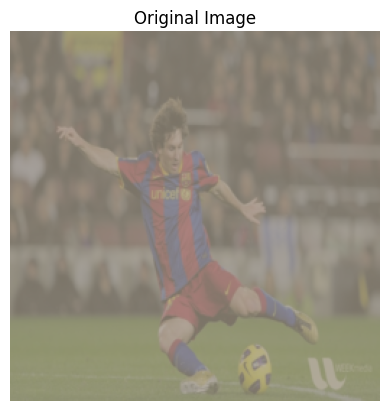

Output shape: torch.Size([1, 7225, 128]) → 7225 patches, 128-dim embeddings


In [ ]:
url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/messi5.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])
img_tensor = transform(img)

plt.imshow((img_tensor.permute(1,2,0) * torch.tensor([0.229,0.224,0.225])[None,None,:]
            + torch.tensor([0.485,0.456,0.406])[None,None,:]).clamp(0,1))
plt.title("Original Image")
plt.axis("off")
plt.show()

## TODO: Try patch_size = 16 and patch_size = 3 seperately
patch_size =
patcher = PatchEmbedding(img_size=256, patch_size=patch_size, in_chans=3, embed_dim=128)
with torch.no_grad():
    x = patcher(img_tensor.unsqueeze(0))
print(f"Output shape: {x.shape} → {x.shape[1]} patches, {x.shape[2]}-dim embeddings")

In [ ]:
# TODO: Run this cell
patches = img_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
patches = patches.permute(1,2,0,3,4).reshape(-1, patch_size, patch_size, 3)
grid_size = int((len(patches)) ** 0.5)
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow((patches[i] * torch.tensor([0.229,0.224,0.225])[None,None,:] +
               torch.tensor([0.485,0.456,0.406])[None,None,:]).clamp(0,1).numpy())
    ax.axis("off")
plt.suptitle(f"Image split into {(256//patch_size)}x{(256//patch_size)} = {len(patches)} patches", fontsize=12)
plt.show()

plt.imshow(x.squeeze(0).norm(dim=1).view(256//patch_size, 256//patch_size).numpy(), cmap='viridis')
plt.colorbar()
plt.title("Patch Embedding Magnitude Heatmap")
plt.show()

## Transformer Encoder Block

Same as what we implemented in discussion 8. Each block has two main parts:
1. **Multi-head Self-Attention** — learns how each patch relates to others globally.
2. **Feed-forward MLP** — processes features of each token independently.

Residual connections and LayerNorm ensure gradient flow and stable training.
This design mirrors the original Attention architecture.


In [ ]:
# Transformer Encoder Block
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Multi-head Attention
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        # Feed-forward MLP
        x = x + self.mlp(self.norm2(x))
        return x

## Vision Transformer (ViT) Overview

ViT treats an image as a sequence of patch embeddings:
1. A **[CLS] token** (learned parameter) is prepended — it aggregates global information.
2. **Positional embeddings** are added to retain spatial relationships.
3. The sequence passes through several **Transformer blocks**.
4. The final `[CLS]` output is sent to the **classification head** (linear layer).

This enables ViT to learn relationships across all image regions without convolution.

In [ ]:
# Vision Transformer
class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=128, depth=6, num_heads=4, mlp_ratio=4.0, dropout=0.1):  # ✅ 添加 mlp_ratio
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        # class token + position embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        # Transformer encoder
        self.blocks = nn.Sequential(
            *[TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)]
        )
        self.norm = nn.LayerNorm(embed_dim)

        # classification head
        self.head = nn.Linear(embed_dim, num_classes)

        # initialization
        self.apply(self._init_weights)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        x = self.blocks(x)
        x = self.norm(x)
        cls_output = x[:, 0]
        return self.head(cls_output)

## Train setting

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ViT(img_size=32, patch_size=8, embed_dim=256, depth=6, num_heads=8, num_classes=10, dropout=0.2).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-1312691458.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


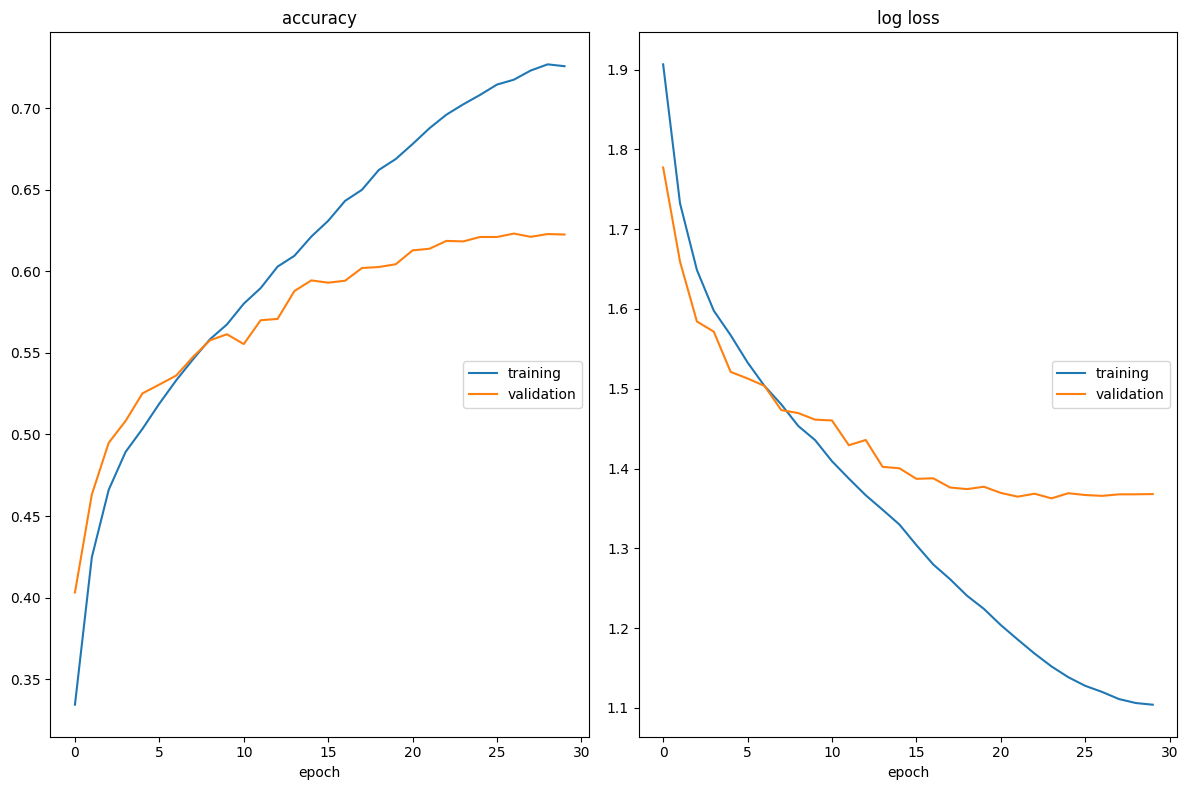

accuracy
	training         	 (min:    0.334, max:    0.727, cur:    0.726)
	validation       	 (min:    0.403, max:    0.623, cur:    0.623)
log loss
	training         	 (min:    1.104, max:    1.907, cur:    1.104)
	validation       	 (min:    1.363, max:    1.777, cur:    1.368)
Epoch 29 | Train Acc=72.56% 

Test accuracy: 62.25


In [ ]:
!pip install livelossplot -q
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

liveloss = PlotLosses()

def train_one_epoch(epoch):
    model.train()
    total, correct, loss_sum = 0, 0, 0
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loss_sum += loss.item()
        total += labels.size(0)
        correct += outputs.argmax(1).eq(labels).sum().item()
    scheduler.step()
    train_loss = loss_sum / len(trainloader)
    train_acc = 100 * correct / total
    return train_loss, train_acc


def test():
    model.eval()
    total, correct, loss_sum = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            total += labels.size(0)
            correct += outputs.argmax(1).eq(labels).sum().item()
    test_loss = loss_sum / len(testloader)
    test_acc = 100 * correct / total
    return test_loss, test_acc


# train
epochs = 30
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(epoch)
    test_loss, test_acc = test()

    # liveloss update
    logs = {
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_acc / 100.0,
        'val_accuracy': test_acc / 100.0
    }
    liveloss.update(logs)
    liveloss.send()
    print(f"Epoch {epoch:02d} | Train Acc={train_acc:.2f}% ")
print("\nTest accuracy:", test_acc)

## Comparing Custom ViT vs timm Model

After training our custom implementation, we also try the `timm` library’s
pre-built ViT-Tiny (vit_tiny_r_s16_p8_224)model (without pre-trainning).

You can find the details of model structure at: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py

### Exercise: define the training for loaded modle

In [ ]:
# TODO:
model = timm.create_model('vit_tiny_r_s16_p8_224', pretrained=False, num_classes=10, dynamic_img_size=True)
model.to(device)

criterion = __fill__
optimizer = __fill__
scheduler = __fill__
scaler = __fill__

In [ ]:
liveloss = PlotLosses()

def train_one_epoch(epoch):
    model.train()
    total, correct, loss_sum = 0, 0, 0
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loss_sum += loss.item()
        total += labels.size(0)
        correct += outputs.argmax(1).eq(labels).sum().item()
    scheduler.step()
    train_loss = loss_sum / len(trainloader)
    train_acc = 100 * correct / total
    return train_loss, train_acc


def test():
    model.eval()
    total, correct, loss_sum = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            total += labels.size(0)
            correct += outputs.argmax(1).eq(labels).sum().item()
    test_loss = loss_sum / len(testloader)
    test_acc = 100 * correct / total
    return test_loss, test_acc


# train
epochs = 30
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(epoch)
    test_loss, test_acc = test()

    # liveloss update
    logs = {
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_acc / 100.0,
        'val_accuracy': test_acc / 100.0
    }
    liveloss.update(logs)
    liveloss.send()
    print(f"Epoch {epoch:02d} | Train Acc={train_acc:.2f}% ")
print("\nTest Accuracy: ", test_acc)

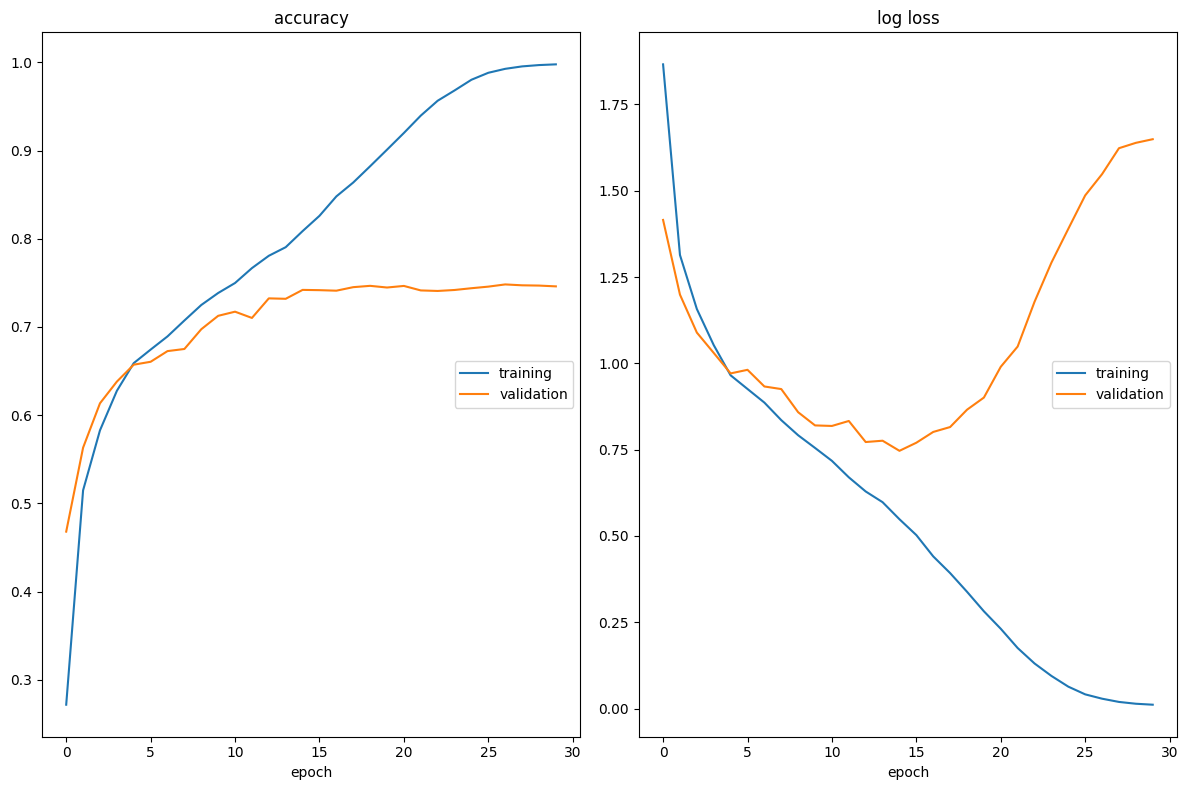

accuracy
	training         	 (min:    0.272, max:    0.998, cur:    0.998)
	validation       	 (min:    0.468, max:    0.748, cur:    0.746)
log loss
	training         	 (min:    0.011, max:    1.866, cur:    0.011)
	validation       	 (min:    0.747, max:    1.649, cur:    1.649)
Epoch 29 | Train Acc=99.77% 

Test Accuracy:  74.6


In [ ]:
# example